In [1]:
from pathlib import Path
import time
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

exec(open("../functions.py").read())

In [2]:
# set basic parameters and subdirectory
part_n = 500
e_part_r = 0.8
e_mean = 4
ei_std_s = [4, 4]
waiting_time = 300
interval_len = 1300
freq = 0.1
subdirectory = ("{:n}_".format(part_n)
                + "{:n}_".format(e_part_r)
                + "{:n}_".format(e_mean)
                + "{0:n}-{1:n}/".format(ei_std_s[0],
                                        ei_std_s[1]))
#Path(subdirectory).mkdir()
print(ei_spectral_radius_fct(e_part_r, ei_std_s))

seed = 1695418797#round(time.time())
subdirectory = (subdirectory + "{:n}_".format(seed)
                + "{0:n}-{1:n}_".format(interval_len, 
                                        waiting_time)
                + "{:n}/".format(freq))
#Path(subdirectory).mkdir()
print(subdirectory)

4.0
500_0.8_4_4-4/1695418797_1300-300_0.1/


In [3]:
# generate and save parameters for simulation
key = jax.random.PRNGKey(seed)

sub_part_r_s = jnp.asarray([e_part_r, 1 - e_part_r])
sub_part_n_s = sub_part_n_s_fct(part_n, sub_part_r_s)
unscaled_mean = ei_mean_balancer(sub_part_r_s, e_mean)
unscaled_std = jnp.tile(jnp.asarray([ei_std_s]), (2, 1))
connectivity_n = 5
in_r = 1.
rewiring_prob = 1.
[connectivity_s, key] = row_sum_removing_sparsifier(connectivity_s_generator(sub_part_n_s,
                                                                             unscaled_mean, unscaled_std,
                                                                             connectivity_n,
                                                                             key),
                                                    sub_part_n_s, in_r, rewiring_prob)
jnp.savez(subdirectory + "parameter_s_1.npz",
          sub_part_r_s, sub_part_n_s, unscaled_mean, unscaled_std,
          connectivity_n,
          in_r, rewiring_prob,
          connectivity_s)

sub_part_n_s_ext_gen = jnp.asarray([part_n])
ext_part_n = part_n // 100
ext_sub_part_r_s = jnp.asarray([1.])
ext_sub_part_n_s = sub_part_n_s_fct(ext_part_n, ext_sub_part_r_s)
unscaled_ext_mean = jnp.asarray([[0.]])
unscaled_ext_std = jnp.asarray([[1.]])
ext_connectivity_n = 3
[ext_connectivity_s, key] = ext_connectivity_s_generator(sub_part_n_s_ext_gen, ext_sub_part_n_s,
                                                         unscaled_ext_mean, unscaled_ext_std,
                                                         ext_connectivity_n,
                                                         key)
jnp.savez(subdirectory + "parameter_s_2.npz",
          sub_part_n_s_ext_gen, 
          ext_part_n, ext_sub_part_r_s,
          ext_sub_part_n_s,
          unscaled_ext_mean, unscaled_ext_std, 
          ext_connectivity_n,
          ext_connectivity_s)

phase_n = 3
[phase_s, key] = phase_s_generator(ext_part_n, phase_n, key)
jnp.savez(subdirectory + "parameter_s_3.npz",
          phase_n,
          phase_s)

amp_s = jnp.expand_dims(jnp.asarray([0.2, 0.5, 1., 8., 12.]), 
                        # or (wave_n, ext_part_n) array so different ext parts have different amps
                        1)
freq_s = jnp.full(amp_s.shape, freq)
wave_s = jnp.concatenate([amp_s, freq_s], axis = 1)
wave_n = wave_s.shape[0]
jnp.savez(subdirectory + "parameter_s_4.npz",
          amp_s, freq_s,
          wave_s,
          wave_n)

init_condition_n = 5
ext_condition_n = ext_connectivity_n * phase_n
init_condition_n_free = init_condition_n * ext_condition_n
[init_condition_s, key] = init_condition_s_generator(part_n, 
                                                           jnp.full((part_n, ), 0), jnp.identity(part_n), 
                                                           init_condition_n_free, key)
jnp.savez(subdirectory + "parameter_s_5.npz",
          init_condition_n,
          ext_condition_n, init_condition_n_free,
          init_condition_s)

label_s = jnp.asarray([1])
label_s_free = jnp.asarray([0])
time_interval_s = jnp.asarray([[0, interval_len]])
window_len_s = jnp.asarray([10, 20, 50, 100, 200]) # used length = 1000
jnp.savez(subdirectory + "parameter_s_6.npz",
          label_s, label_s_free,
          time_interval_s,
          window_len_s)
labeled_time_interval_s = [time_interval_s, label_s]
labeled_time_interval_s_free = [time_interval_s, label_s_free]

resolution = 24
jnp.savez(subdirectory + "parameter_s_7.npz",
          resolution)

condition_n_s = jnp.asarray([connectivity_n, wave_n, ext_connectivity_n, phase_n,
                             init_condition_n])
condition_n_s_free = jnp.asarray([connectivity_n, 1, 1, 1,
                                  init_condition_n_free])
samp_separation = samp_separation_fct(interval_len - waiting_time, resolution, window_len_s, 48, 10)

In [4]:
# load parameters
[sub_part_r_s, sub_part_n_s, unscaled_mean, unscaled_std,
 connectivity_n,
 in_r, rewiring_prob,
 connectivity_s] = load_as_list(subdirectory + "parameter_s_1.npz")

[sub_part_n_s_ext_gen, 
 ext_part_n, ext_sub_part_r_s,
 ext_sub_part_n_s,
 unscaled_ext_mean, unscaled_ext_std, 
 ext_connectivity_n,
 ext_connectivity_s] = load_as_list(subdirectory + "parameter_s_2.npz")

[phase_n,
 phase_s] = load_as_list(subdirectory + "parameter_s_3.npz")

[amp_s, freq_s,
 wave_s,
 wave_n] = load_as_list(subdirectory + "parameter_s_4.npz")

[init_condition_n,
 ext_condition_n, init_condition_n_free,
 init_condition_s] = load_as_list(subdirectory + "parameter_s_5.npz")

[label_s, label_s_free,
 time_interval_s,
 window_len_s] = load_as_list(subdirectory + "parameter_s_6.npz")
labeled_time_interval_s = [time_interval_s, label_s]
labeled_time_interval_s_free = [time_interval_s, label_s_free]

[resolution] = load_as_list(subdirectory + "parameter_s_7.npz")

condition_n_s = jnp.asarray([connectivity_n, wave_n, ext_connectivity_n, phase_n,
                             init_condition_n])
condition_n_s_free = jnp.asarray([connectivity_n, 1, 1, 1,
                                  init_condition_n_free])
samp_separation = samp_separation_fct(interval_len - waiting_time, resolution, window_len_s, 48, 10)

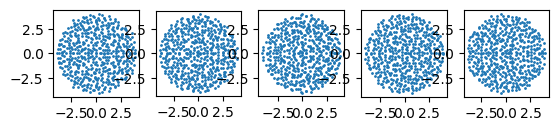

In [5]:
# plot spectra
[fig, subfig_s] = plt.subplots(1, int(connectivity_n))
for connectivity_idx in range(connectivity_n):
  temp_spectrum = jnp.linalg.eig(connectivity_s[connectivity_idx])[0]
  subfig_s[connectivity_idx].plot(jnp.real(temp_spectrum), jnp.imag(temp_spectrum),
                                  linestyle="", marker=".", markersize = 2)
  subfig_s[connectivity_idx].set_aspect('equal')

In [6]:
# initialize and run stats
kernel_power = "inf"
def short_multi_len_pr_tr_os_s_fct(traj):
  return(multi_len_pr_tr_os_s_fct(traj[..., (waiting_time * resolution):], resolution,
                                  window_len_s, int(samp_separation), kernel_power))

start_time = time.time()

stat_s_free = multi_len_pr_tr_os_s_initializer(condition_n_s_free, window_len_s)
stat_s_free = stat_s_fct(connectivity_s, wave_s[:1], ext_connectivity_s[:1], phase_s[:1], init_condition_s,
                         labeled_time_interval_s_free, resolution,
                         short_multi_len_pr_tr_os_s_fct, stat_s_free)
np.savez_compressed(subdirectory + "stats_free.npz", *stat_s_free) # jax has not implemented savez_compressed as of 23/08/23

stat_s = multi_len_pr_tr_os_s_initializer(condition_n_s, window_len_s)
stat_s = stat_s_fct(connectivity_s, wave_s, ext_connectivity_s, phase_s, init_condition_s[::ext_condition_n],
                    labeled_time_interval_s, resolution, 
                    short_multi_len_pr_tr_os_s_fct, stat_s)
np.savez_compressed(subdirectory + "stats.npz", *stat_s)

end_time = time.time()
print("took {:.2f} mins".format((end_time - start_time) / 60))

[5, 'connectivity_n']
[1, 'wave_n']
[1, 'ext_connectivity_n']
[1, 'phase_n']
[45, 'init_condition_n']
3 stats
expecting 20.33 mins
[5, 'connectivity_n']
[5, 'wave_n']
[3, 'ext_connectivity_n']
[3, 'phase_n']
[5, 'init_condition_n']
3 stats
expecting 108.75 mins
took 127.77 mins


In [7]:
# load trajs
stat_s_free = load_as_list(subdirectory + "stats_free.npz")
stat_s = load_as_list(subdirectory + "stats.npz")

plotting

In [8]:
foo = jrandom.normal(jrandom.PRNGKey(seed), (2,1500, ))
long_bar = size_s_fct(es_s_fct(cov_s_fct(foo, mean_s_fct(foo)))[0])
bar = multi_len_pr_tr_os_s_fct(foo, 56, jnp.asarray([20,100,200]), 100, "inf")[1]
print(long_bar, bar)

1.0516938 [1.0299333 1.0299333 1.0299333 1.0516938]


In [9]:
[pr_s_free, tr_s_free, os_s_free] = stat_s_free
[pr_s, tr_s, os_s] = stat_s

[0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0]

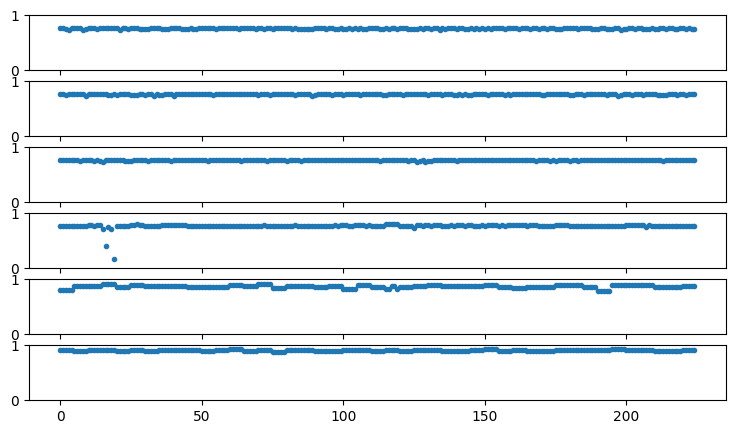

In [10]:
#making sure nothing is strange from the trs
[fig, subfig_s] = plt.subplots(wave_n + 1, 1, figsize = (9, 5))
subfig_s[0].plot(tr_s_free[..., -1].flatten(), label = 0., 
                 marker='.', linestyle='')
for wave_idx in range(wave_n):
  subfig_s[wave_idx + 1].plot(tr_s[:, wave_idx, ..., -1].flatten(), label = amp_s[wave_idx, 0],
                              marker='.', linestyle='')
plt.setp(subfig_s, ylim=(0,1))

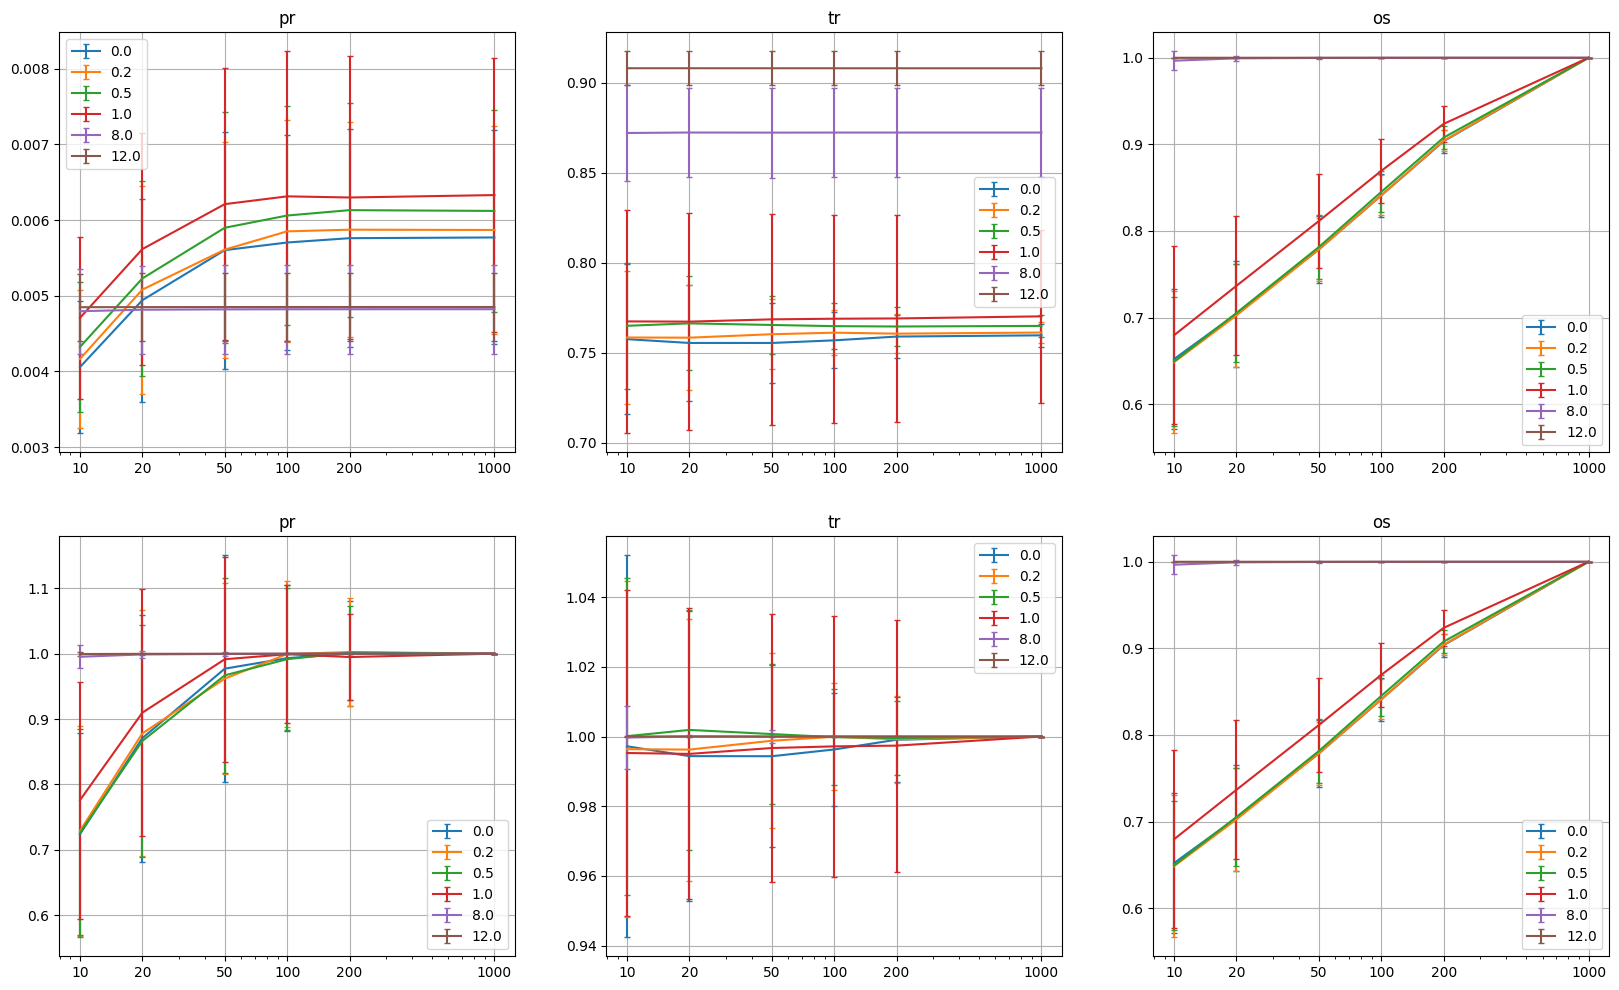

In [11]:
def temp_val_fct(stat_s_wrt_amp_s):
  return([jnp.concatenate([fct(stat_s, axis = (0,2,3,4))
                           for stat_s in stat_s_wrt_amp_s], axis = 0)
          for fct in [jnp.mean, jnp.std]])

def temp_r_fct(stat_s_wrt_amp_s):
  return([jnp.concatenate([fct(stat_s / stat_s[...,-1:], axis = (0,2,3,4))
                           for stat_s in stat_s_wrt_amp_s], axis = 0)
          for fct in [jnp.mean, jnp.std]])

val_r_stat_s = [[temp_val_fct([pr_s_free, pr_s]), 
                 temp_val_fct([tr_s_free, tr_s]), 
                 temp_val_fct([os_s_free, os_s])],
                [temp_r_fct([pr_s_free, pr_s]), 
                 temp_r_fct([tr_s_free, tr_s]), 
                 temp_r_fct([os_s_free, os_s])]]

plot_amp_s = jnp.insert(amp_s, 0, 0)
plot_window_len_s = jnp.append(window_len_s, interval_len - waiting_time)
[fig, subfig_s] = plt.subplots(2, 3, figsize = (20,12))
for val_or_r in range(2):
  subfig_s[val_or_r,0].title.set_text("pr")
  subfig_s[val_or_r,1].title.set_text("tr")
  subfig_s[val_or_r,2].title.set_text("os")
  for stat_idx in range(3):
    for amp_idx in range(wave_n + 1):
      subfig_s[val_or_r,stat_idx].errorbar(plot_window_len_s,
                           val_r_stat_s[val_or_r][stat_idx][0][amp_idx],
                           yerr = val_r_stat_s[val_or_r][stat_idx][1][amp_idx],
                           capsize = 2, label = str(plot_amp_s[amp_idx]))
    subfig_s[val_or_r,stat_idx].set_xscale("log")
    subfig_s[val_or_r,stat_idx].set_xticks(plot_window_len_s, labels = plot_window_len_s)
    subfig_s[val_or_r,stat_idx].legend()
    subfig_s[val_or_r,stat_idx].grid()